In [25]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import uniform, exponential
import numpy as np
import pandas as pd
import seaborn as sb
from lifelines.utils import survival_table_from_events
from lifelines.plotting import plot_lifetimes
import stanity
import survivalstan
import io
import requests
from cohorts.utils import strip_column_names

## plot/figure defaults
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['figure.titlesize'] = 'large'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
## utility function to plot survival curve estimates
def plot_cum_survival(t, event):
    # at each time t, calculate the cumulative survival
    cum_survival = survival_table_from_events(t, event)
    cum_survival.reset_index(0, inplace=True)
    cum_survival.rename(columns = {'event_at': 't'}, inplace=True)
    cum_survival['Survival'] = cum_survival['at_risk']/max(cum_survival['at_risk'])
    # create figure
    fig = plt.figure()
    _ = plt.plot(cum_survival.t, cum_survival.Survival, 'rs')
    _ = plt.xlabel('time')
    return(cum_survival)


In [27]:
models = survivalstan.utils.read_files('stan')

stan/exp_survival_model.stan
stan/pem_survival_model_unstructured.stan
stan/pem_survival_model_gamma.stan
stan/pem_survival_model_randomwalk_bspline_est_xi.stan
stan/pem_survival_model_randomwalk.stan
stan/pem_survival_model_randomwalk_bspline.stan
stan/weibull_survival_model.stan


# Analysis of TCGA data

In [28]:
## example data from TCGA-BLCA cohort
url = 'http://www.cbioportal.org/webservice.do?cmd=getClinicalData&case_set_id=blca_tcga_all'
s = requests.get(url).content
c = pd.read_csv(io.StringIO(s.decode('utf-8')), delimiter='\t')
tcga = c.rename(columns=strip_column_names(c.columns))
tcga = tcga.dropna(subset=['os_months','os_status'])

In [29]:
## inspect key explanatory variables
tcga.loc[:,['case_id', 'os_status', 'os_months', 'age', 'histological_subtype',
         'dfs_status', 'dfs_months']].head()

,case_id,os_status,os_months,age,histological_subtype,dfs_status,dfs_months
0,TCGA-GV-A40G-01,LIVING,19.05,77.0,Non-Papillary,DiseaseFree,19.05
1,TCGA-E7-A7DU-01,LIVING,0.92,73.0,Papillary,DiseaseFree,0.92
2,TCGA-CF-A5UA-01,LIVING,11.99,67.0,Papillary,DiseaseFree,11.99
3,TCGA-FD-A5BT-01,DECEASED,10.78,84.0,Non-Papillary,NaN,NaN
4,TCGA-DK-A3X1-01,LIVING,66.00,78.0,Non-Papillary,DiseaseFree,66.00


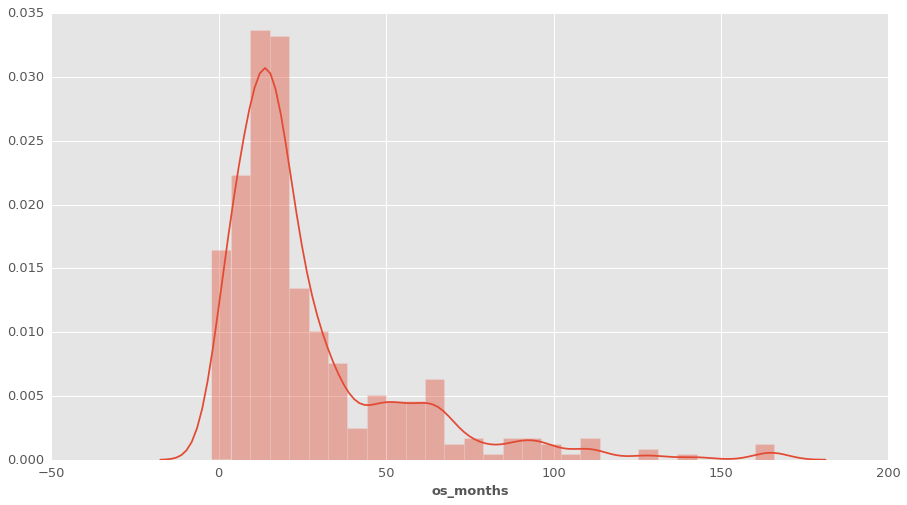

In [30]:
## distribution of survival times
sb.distplot(tcga.os_months)

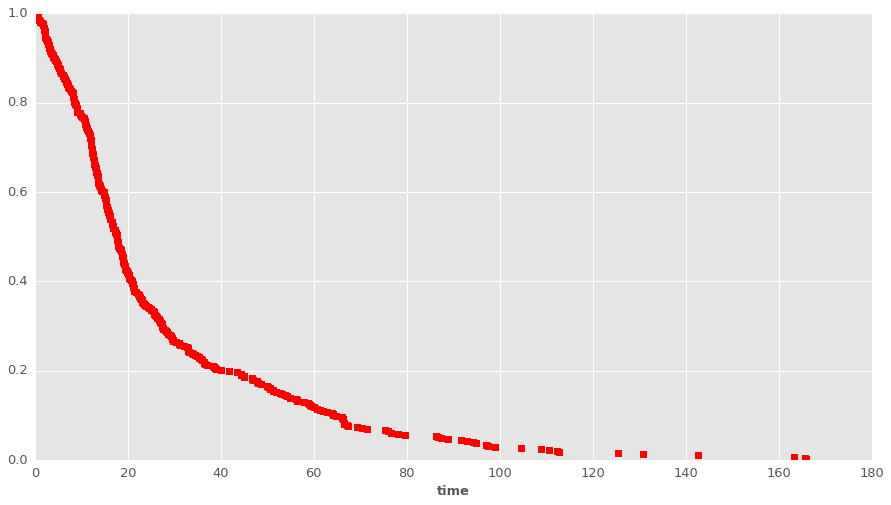

In [31]:
tcga['event'] = tcga['os_status']=='DECEASED'
tcga['time'] = tcga['os_months']
tcga = tcga.query('time >= 0')
a = plot_cum_survival(event=tcga.event, t=tcga.time)

In [32]:
tcga_long = survivalstan.prep_data_long_surv(df=tcga, event_col='event', time_col='time')


In [33]:
models = survivalstan.utils.read_files('stan')

stan/exp_survival_model.stan
stan/pem_survival_model_unstructured.stan
stan/pem_survival_model_gamma.stan
stan/pem_survival_model_randomwalk_bspline_est_xi.stan
stan/pem_survival_model_randomwalk.stan
stan/pem_survival_model_randomwalk_bspline.stan
stan/weibull_survival_model.stan


# inspect baseline hazard

First we will check our model fit using an *unstructured* baseline hazard

In [ ]:
pem_tcga = survivalstan.fit_stan_survival_model(df=tcga_long,
                                                formula='~ 1',
                                                event_col='end_failure',
                                                timepoint_end_col='end_time',
                                                sample_col='case_id',
                                                model_code=models['pem_survival_model_unstructured.stan'],
                                                model_cohort='TCGA, unstr hazard',
                                                chains=4,
                                                iter=1000
                                                )

Reusing model.


In [ ]:
survivalstan.utils.plot_coefs([pem_tcga], element='baseline_raw')

In [ ]:
pem_tcga2 = survivalstan.fit_stan_survival_model(df=tcga_long,
                                                formula='~ histological_subtype + age',
                                                event_col='end_failure',
                                                timepoint_end_col='end_time',
                                                sample_col='case_id',
                                                model_code=models['pem_survival_model_unstructured.stan'],
                                                model_cohort='TCGA, unstr hazard',
                                                chains=4,
                                                iter=1000
                                                )